# Evaluation


## Imports


In [1]:
# Import external libraries
import torch
import numpy as np
import pandas as pd

from PIL import Image
from pathlib import Path
from torchinfo import summary

In [2]:
# Import internal libraries
from melanoma_classification.model import get_dermmel_classifier_v1
from utils.dermmel import DermMel
from melanoma_classification.utils import (
    production_transform, 
    get_device,
    visualize_single_attention,
    visualize_multihead_as_single_attention,
    visualize_multihead_attention,
)
from evaluation.evaluator import (
    visualize_loss,
    visualize_f1_precision_recall,
    visualize_accuracy,
    create_evaluation_report,
    visualize_confusion_matrix,
    visualize_model_confidence,
)

## Preparations


In [3]:
# Init device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set paths
figure_path = Path("evaluation") / "images"
checkpoint_base_path = Path("checkpoints") / "dermmel_orig_image_test"
training_metrics_filename = "metrics.csv"
final_model_path = Path("..") / "src" / "melanoma_classification" / "weights"
final_model_path.mkdir(exist_ok=True)


### Create & read in model from checkpoints


In [5]:
checkpoint_path = checkpoint_base_path / "checkpoint_epoch_20.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

C:\Users\Qunor\AppData\Local\Temp\ipykernel_27968\3584975421.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

In [6]:
vit = get_dermmel_classifier_v1()
vit.load_state_dict(checkpoint["model_state_dict"])

# Load the model
summary(vit, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 2]                    152,064
├─PatchEmbeddingCNN: 1-1                      [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
├─Dropout: 1-2                                [1, 197, 768]             --
├─ModuleList: 1-3                             --                        --
│    └─TransformerEncoderLayer: 2-2           [1, 197, 768]             --
│    │    └─MultiHeadSelfAttention: 3-1       [1, 197, 768]             2,362,368
│    │    └─LayerNorm: 3-2                    [1, 197, 768]             1,536
│    │    └─Sequential: 3-3                   [1, 197, 768]             4,722,432
│    │    └─LayerNorm: 3-4                    [1, 197, 768]             1,536
│    └─TransformerEncoderLayer: 2-3           [1, 197, 768]             --
│    │    └─MultiHeadSelfAttention: 3-5       [1, 197, 768]      

### Create test dataset & dataloader


In [7]:
test_dataset = DermMel(
    "../data", split="test", transform=production_transform()
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=0
)

c:\Users\Qunor\.pyenv-win-venv\envs\melanoma\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Read-in training metrics


In [8]:
training_metrics = pd.read_csv(checkpoint_base_path / training_metrics_filename)
training_metrics.head()

,epoch,train_loss,train_acc,val_loss,val_acc,train_f1,train_precision,train_recall,val_f1,val_precision,val_recall
0,1,0.077848,64.051676,0.072072,66.900618,0.616613,0.660535,0.578169,0.630986,0.712871,0.565974
1,2,0.072342,69.780940,0.068910,69.371140,0.675382,0.729524,0.628721,0.618931,0.818854,0.497473
2,3,0.071830,69.209886,0.065454,74.396407,0.671067,0.720266,0.628160,0.711757,0.814172,0.632229
3,4,0.070642,70.904325,0.064412,75.968557,0.689448,0.739233,0.645946,0.751452,0.778112,0.726558
4,5,0.070476,70.323909,0.065327,75.940483,0.686697,0.727235,0.650440,0.758115,0.762202,0.754071


## Training analysis


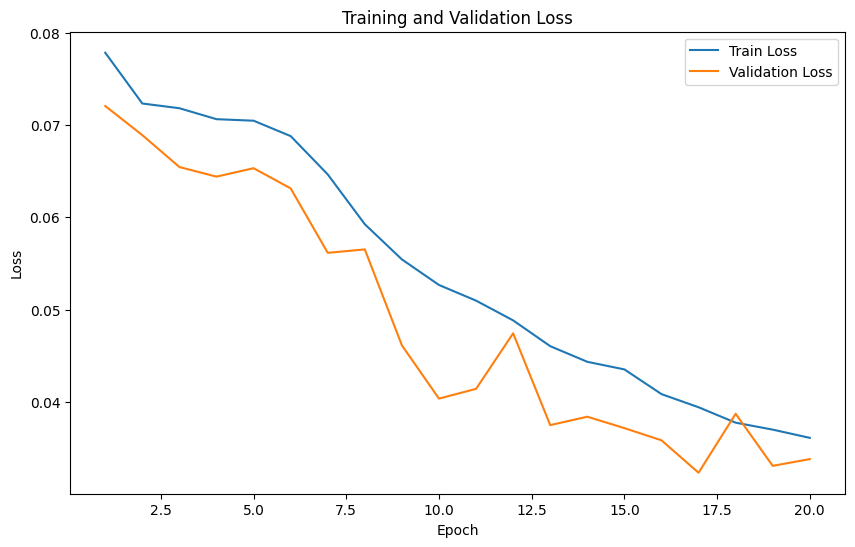

In [9]:
visualize_loss(training_metrics, figure_path / "loss.png")

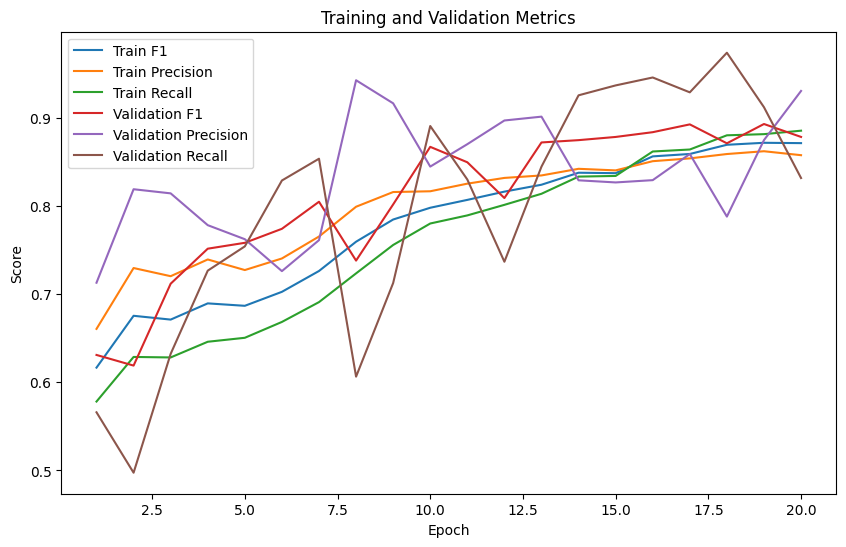

In [10]:
visualize_f1_precision_recall(
    training_metrics, 
    figure_path / "f1_precision_recall.png"
)

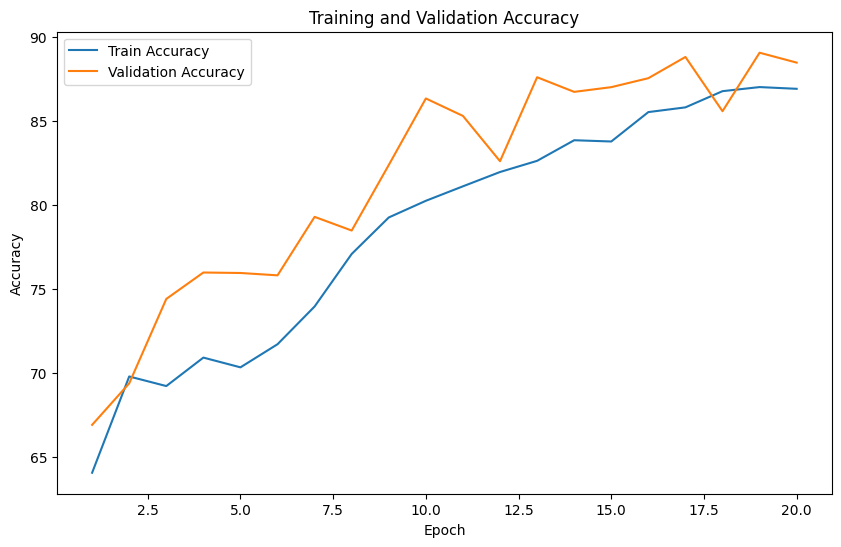

In [11]:
visualize_accuracy(training_metrics, figure_path / "accuracy.png")

## Test model


In [12]:
evaluation_report = create_evaluation_report(
    vit, test_dataloader, test_dataset.classes, device
)

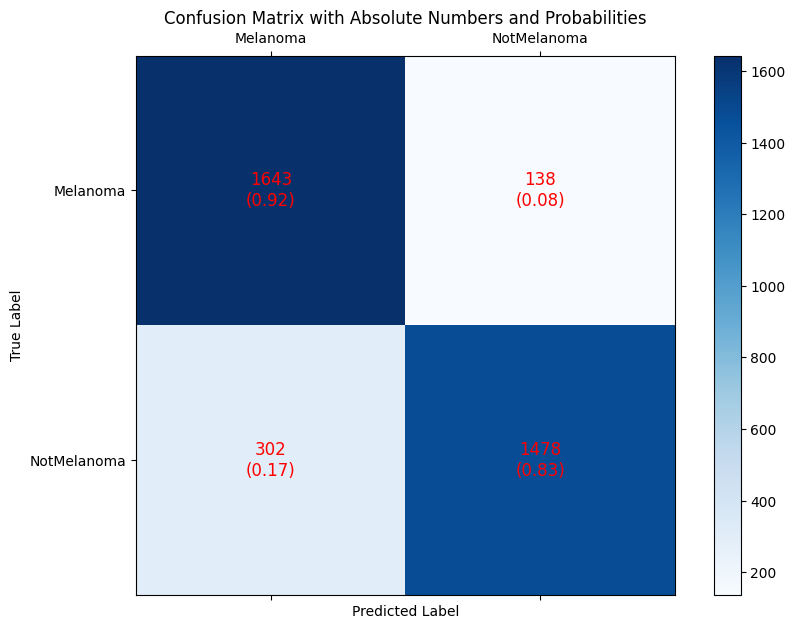

In [13]:
visualize_confusion_matrix(
    evaluation_report,
    test_dataset.classes,
    figure_path / "confusion_matrix.png"
)

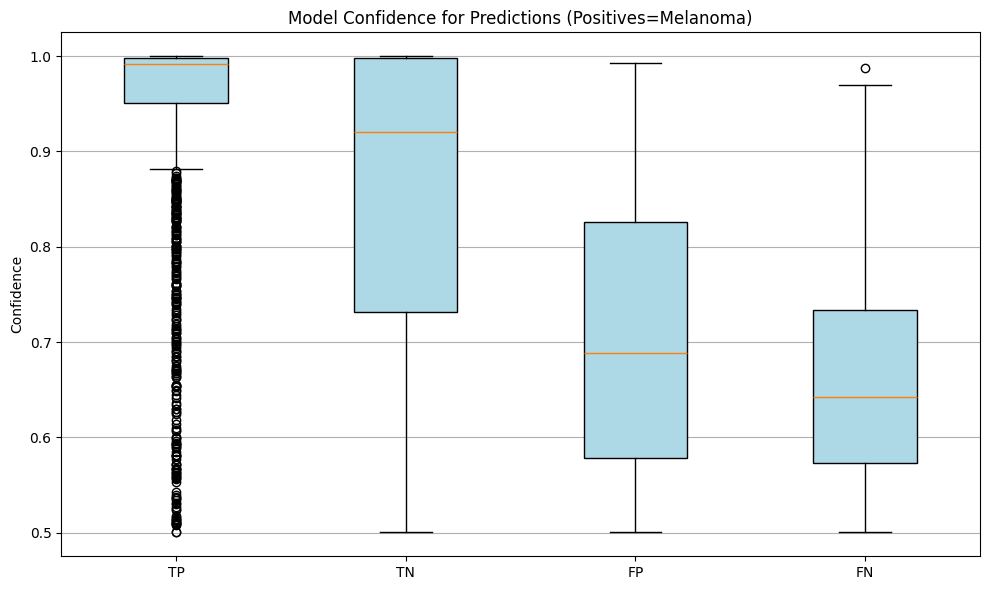

In [14]:
visualize_model_confidence(evaluation_report, figure_path / "model_confidences.png")

## Save only the model


In [15]:
# Save the model to production folder
torch.save(vit.state_dict(), final_model_path / "vit.pth")

## Infer unseen image & visualize attention maps


Image source: [Wikipedia](https://en.wikipedia.org/wiki/Melanoma) 

In [ ]:
# Read and process image
img_path = figure_path / "Melanoma.jpg"
raw_image = Image.open(img_path).convert("RGB")

image = (
    production_transform()(image=np.array(raw_image))["image"]
    .to(device)
    .unsqueeze(0)
)

In [ ]:
# Classify the image
vit.eval()
with torch.no_grad():
    model_outputs = vit(image)
    logits = model_outputs["outputs"]
    attention = model_outputs["attentions"]
    logits = torch.nn.functional.softmax(logits, 1)
    confidence, prediction = torch.max(logits, dim=1)
    confidence, prediction = confidence.item(), prediction.item()

detected = vit.class_map[prediction]
print(f"Found a {detected} sample with confidence {confidence*100:.2f}%.")

In [ ]:
# Visualize the attention maps

# Choose layer to visualize
layer = -1

# Visualize single attention map averaged over all heads and layers
visualize_single_attention(
    raw_image,
    attention,
    img_path=img_path / "single_attention.png"
)

# Visualize multihead attention maps as a single attention map for a specific
# layer
visualize_multihead_as_single_attention(
    raw_image,
    attention,
    layer=layer,
    img_path=img_path / f"multihead_as_single_attention{layer}.png"
)

# Visualize multihead attention maps for a specific layer separately for each
# head
visualize_multihead_attention(
    raw_image, 
    attention, 
    img_path=img_path / f"multihead_attention{layer}.png"
)